In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# SAM ile nesne maskelerini otomatik olarak oluşturma

SAM (Segment Anything Model) otomatik maskeleme, bilgisayarla görü ve görüntü segmentasyonu alanında kullanılan bir tekniktir. SAM, geniş bir nesne yelpazesini doğru bir şekilde tanımlayabilen ve segmentlere ayırabilen bir modeldir. Bu model, kullanıcıların manuel olarak etiketleme yapmalarını gerektirmeden, görüntülerdeki nesneleri otomatik olarak segmentlere ayırabilir. İşte SAM otomatik maskelemenin detayları:

### 1. **Temel Kavramlar**
   - **Segmentasyon:** Görüntüdeki farklı nesneleri veya bölgeleri belirlemek ve ayırmak amacıyla yapılan işlemdir. Segmentasyon, görüntüyü bir dizi anlamlı parçaya ayırarak her bir parçayı bağımsız olarak analiz etmeyi sağlar.
   - **Maskeleme:** Segmentasyon işleminin bir parçası olarak, belirli bir nesneyi veya bölgeyi görüntü üzerinde izole etmek için kullanılan bir tekniktir. Maskeleme, belirli bir nesnenin arka plandan ayrılmasına yardımcı olur.

### 2. **SAM Modelinin İşleyişi**
   - **Ön Eğitim ve Özellik Öğrenme:** SAM, genellikle büyük ve çeşitli veri kümesi üzerinde önceden eğitilmiş bir modeldir. Bu, modelin çeşitli nesneleri tanıma ve segmentasyon yapma yeteneğini geliştirir.
   - **Otomatik Maskeleme:** SAM, görüntüdeki her nesne için otomatik olarak bir maske oluşturur. Bu maskeler, nesnelerin sınırlarını belirler ve onları arka plandan ayırır.
   - **Kullanıcı Girdisi:** Bazı SAM modelleri, kullanıcıdan belirli bölgeleri işaretlemesini isteyebilir, ancak çoğu durumda bu tür girdiler gerekmez. Model, kendi başına görüntüdeki nesneleri tespit edip maskeleyebilir.

## Set-up

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


PyTorch version: 2.3.1+cu121
Torchvision version: 0.18.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ag27ksm5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ag27ksm5
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=e66964cb9021b6b7389ec0d821b2fce25fea8bea003cfefc7de37346844d1008
  Stored in directory: /tmp/pip-ephem-wheel-cache-ubr1m960/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-08-13 22:20:30--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Gerekli kütüphanelerin kurulması

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# Maske gösterim fonksiyonu
Bu Python kodu, matplotlib kütüphanesi ve NumPy kullanarak bir görüntü üzerinde segmentasyon sonuçlarını (maskeleri) görselleştirmek için yazılmış bir fonksiyondur. Fonksiyon, segmentasyon maskelerini renkli olarak gösterir ve her maskeye rastgele bir renk atar.

### Fonksiyonun Açıklaması




1. **Boş Liste Kontrolü:**
   ```python
   if len(anns) == 0:
       return
   ```
   - Eğer `anns` (annotation'lar) listesi boşsa, fonksiyon hiçbir şey yapmadan döner. Bu, segmentasyon sonuçları olmadığında fonksiyonun çalışmasını önler.

2. **Anotasyonları Alanlarına Göre Sıralama:**
   ```python
   sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
   ```
   - `anns` listesindeki her bir anotasyon `area` (alan) özelliğine göre azalan sırayla sıralanır. Bu, en büyük maskelerin önce gösterilmesini sağlar.

3. **Matplotlib Eksenlerini Alma:**
   ```python
   ax = plt.gca()
   ax.set_autoscale_on(False)
   ```
   - Mevcut bir matplotlib ekseni (`ax`) alınır ve otomatik ölçekleme kapatılır. Bu, görüntü üzerinde sabit bir ölçekleme sağlar.

4. **Boş Bir Görüntü Oluşturma:**
   ```python
   img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
   img[:,:,3] = 0
   ```
   - Segmentasyon maskelerinin boyutlarıyla uyumlu olarak tamamen beyaz (her pikselin değeri 1 olan) bir görüntü (`img`) oluşturulur. `4` kanalı, RGBA (Kırmızı, Yeşil, Mavi, Alfa) değerleri için kullanılır.
   - `img[:,:,3] = 0` ifadesi, görüntüdeki alfa kanalını sıfır yaparak görüntüyü başlangıçta tamamen şeffaf hale getirir.

5. **Maskeleri Renkli Olarak Görselleştirme:**
   ```python
   for ann in sorted_anns:
       m = ann['segmentation']
       color_mask = np.concatenate([np.random.random(3), [0.35]])
       img[m] = color_mask
   ```
   - Her anotasyon (`ann`) için maskeyi (`m`) alır. Maskenin içindeki piksellerin, renkli maskenin değerleriyle güncellenmesi sağlanır.
   - `np.random.random(3)` ifadesi, RGB renk değerleri için rastgele bir renk oluşturur. `[0.35]` ise alfa (şeffaflık) kanalının değeridir. Bu, maskeyi hafif şeffaf hale getirir.
   - `color_mask` bu iki parçayı birleştirir ve `img[m] = color_mask` ifadesi, maskenin piksellerini bu renk ile günceller.

6. **Görüntüyü Gösterme:**
   ```python
   ax.imshow(img)
   ```
   - `img` görüntüsü, matplotlib ekseninde (`ax`) görüntülenir. Bu, segmentasyon maskelerini renkli olarak gösterir.


In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Örnek görüntü

In [ ]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

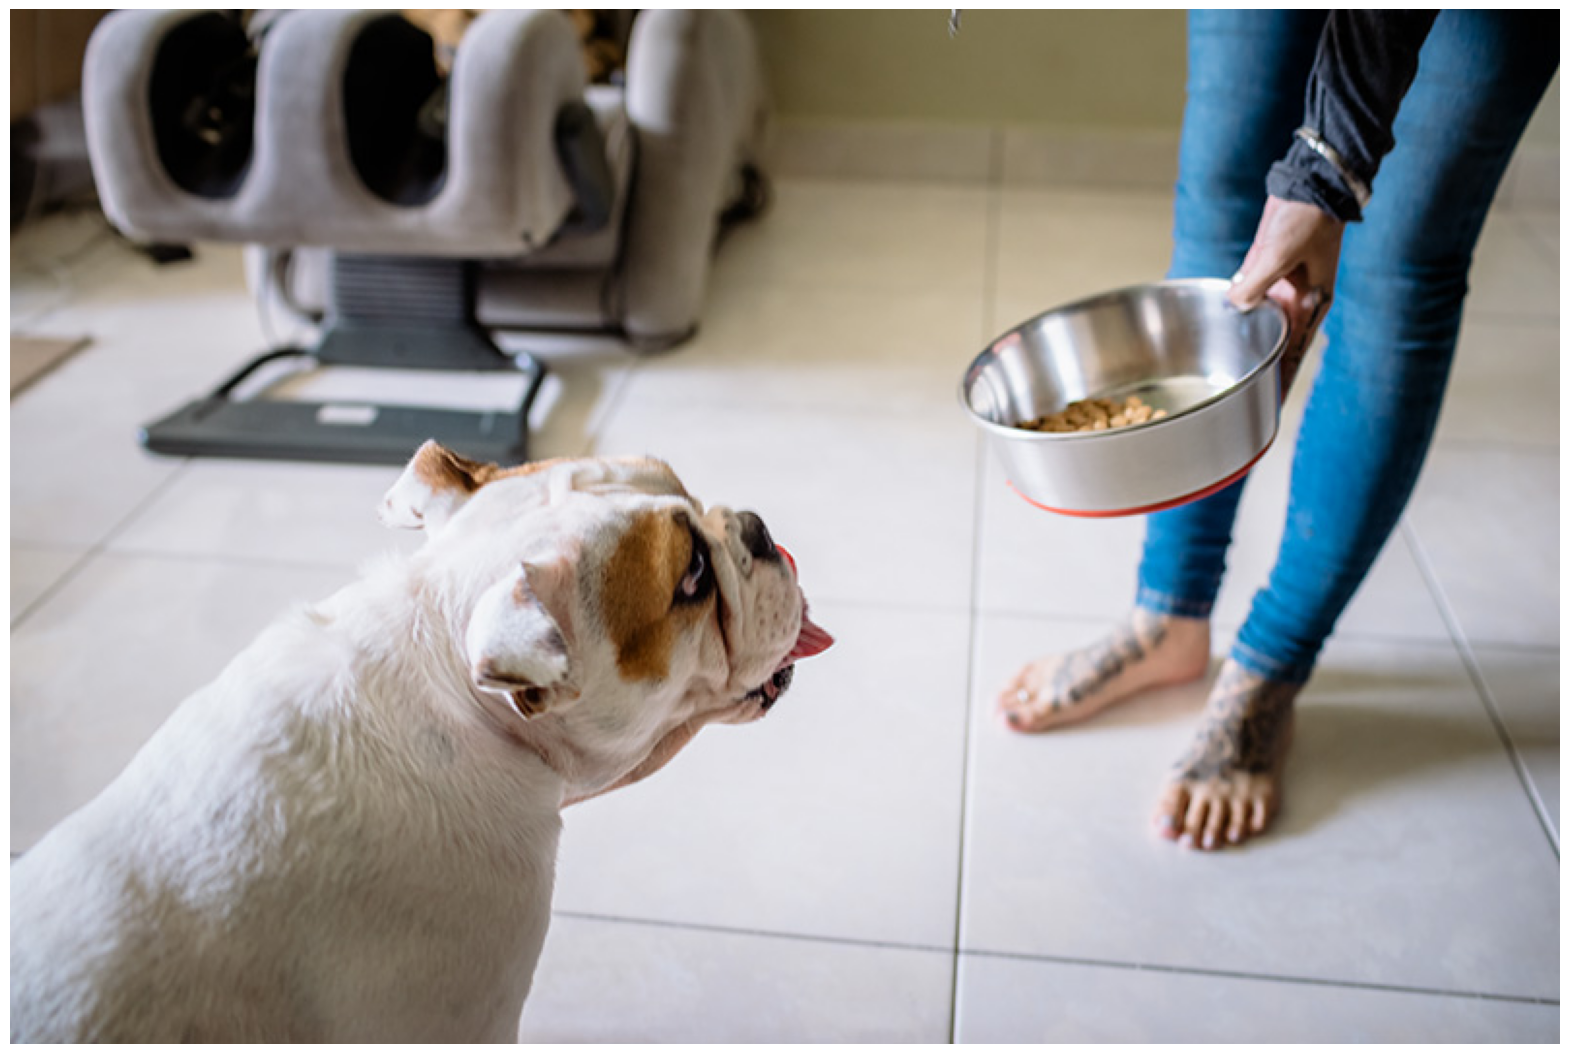

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Otomatik maske üretme

### **Modül ve Sınıfları İçe Aktarmak**

```python
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
```
- Bu satır, `segment_anything` adlı modülden gerekli sınıfları içe aktarır:
  - `sam_model_registry`: SAM modelinin kayıtlı türlerinin bulunduğu bir sözlük veya liste.
  - `SamAutomaticMaskGenerator`: Otomatik maskeleme işlemini gerçekleştiren sınıf.
  - `SamPredictor`: SAM modelinin tahmin yapabilen bir sınıf

### 3. **Model ve Aygıt Ayarları**

```python
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
```
- `sam_checkpoint`: Eğitimli SAM modelinin ağırlık dosyasının adı.
- `model_type`: Kullanılacak modelin türü. Bu örnekte `vit_h` (Vision Transformer, büyük boyutlu).
- `device`: Modelin çalışacağı cihaz. `cuda` ifadesi, GPU (CUDA uyumlu) kullanmak anlamına gelir.

### 4. **Modeli Yükleme ve Aygıta Gönderme**

```python
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
```
- `sam_model_registry[model_type]`: Model türüne göre (`vit_h` burada) modelin sınıfını seçer ve oluşturur. `checkpoint` parametresi, modelin önceden eğitilmiş ağırlıklarını yükler.
- `sam.to(device=device)`: Modeli belirtilen cihaz (`cuda`) üzerine taşır. Bu, modelin GPU üzerinde çalışmasını sağlar.

### 5. **Otomatik Maske Üreticisi Oluşturma**

```python
mask_generator = SamAutomaticMaskGenerator(sam)
```
- `SamAutomaticMaskGenerator(sam)`: `sam` modelini kullanarak otomatik maskeler oluşturacak bir `SamAutomaticMaskGenerator` örneği oluşturur. Bu sınıf, modelin segmentasyon işlemlerini otomatik olarak yapmasını sağlar.


In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
masks = mask_generator.generate(image)

Maske oluşturma, her maskenin maske hakkında çeşitli veriler içeren bir sözlük olduğu maskeler üzerinde bir liste döndürür. Bu anahtarlar şunlardır:

- segmentation : maske
- area : maskenin piksel cinsinden alanı
- bbox : maskenin XYWH biçimindeki sınır kutusu
- predicted_iou : maskenin kalitesi için modelin kendi tahmini
- point_coords : bu maskeyi oluşturan örneklenmiş giriş noktası
- stability_score : maske kalitesinin ek bir ölçüsü
- crop_box : bu maskeyi XYWH biçiminde oluşturmak için kullanılan görüntünün kırpılması

In [ ]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


## Tüm maskeleri görüntüle

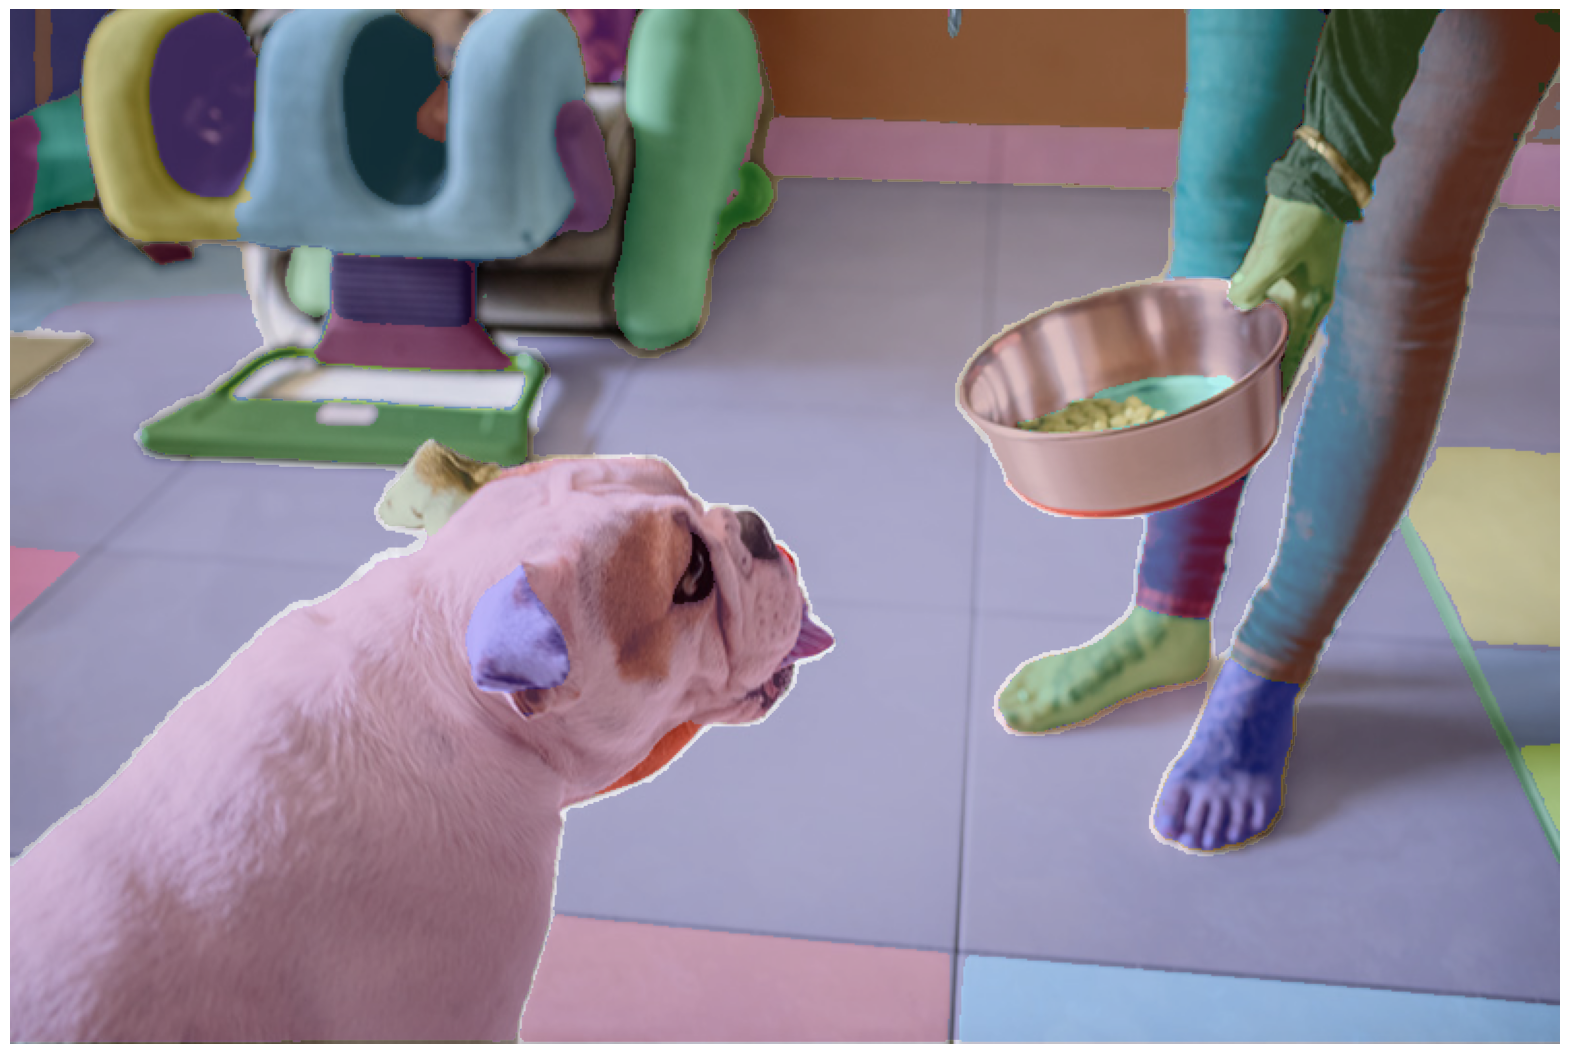

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Otomatik maske oluşturma seçenekleri


### Parametreler ve Anlamları

1. **`model=sam`**
   - Bu parametre, `SamAutomaticMaskGenerator` sınıfına, segmentasyon işlemlerini gerçekleştirecek SAM modelinin örneğini sağlar. Bu, daha önce tanımladığınız `sam` modelini kullanır.

2. **`points_per_side=32`**
   - Bu parametre, her bir kenarın üzerinde kaç tane nokta kullanılacağını belirtir. Yüksek bir değer, daha detaylı ve hassas maskeler oluşturabilir. Genellikle, bu değer segmentasyonun hassasiyetini etkiler.

3. **`pred_iou_thresh=0.86`**
   - Bu, modelin tahmin ettiği maskelerin doğruluğunu belirlemek için kullanılan bir eşik değeridir.
   - `IOU` (Intersection Over Union) skoru, tahmin edilen maske ile gerçek maske arasındaki örtüşmeyi ölçer. Bu eşik değer, sadece belirli bir IOU skoru veya daha yüksek olan maskeleri kabul eder.

4. **`stability_score_thresh=0.92`**
   - Bu eşik değeri, segmentasyon maskelerinin kararlılığını değerlendirir.
   - Daha yüksek bir `stability_score_thresh`, maskelerin daha tutarlı ve güvenilir olmasını sağlar. Maskelerin bu eşik değerinin altında kalanları yoksayar.

5. **`crop_n_layers=1`**
   - Maskelerin kesilmesinde kullanılacak katman sayısını belirler. Daha fazla katman, daha iyi ayrıntı ve kesinlik sağlayabilir, ancak işlem süresini uzatabilir.

6. **`crop_n_points_downscale_factor=2`**
   - Bu faktör, maskelerin kesilmesinde kullanılan nokta sayısının ölçeklendirme faktörüdür. Düşük bir faktör, daha fazla nokta kullanır, bu da daha hassas maskeler oluşturur, ancak işlem süresini artırabilir.

7. **`min_mask_region_area=100`**
   - Bu, maskelenmiş bölgelerin minimum alanını belirler. Bu değerin altında kalan bölgeler yoksayılır. Bu, küçük, önemsiz bölgelerin maskelenmesini engeller.

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

90

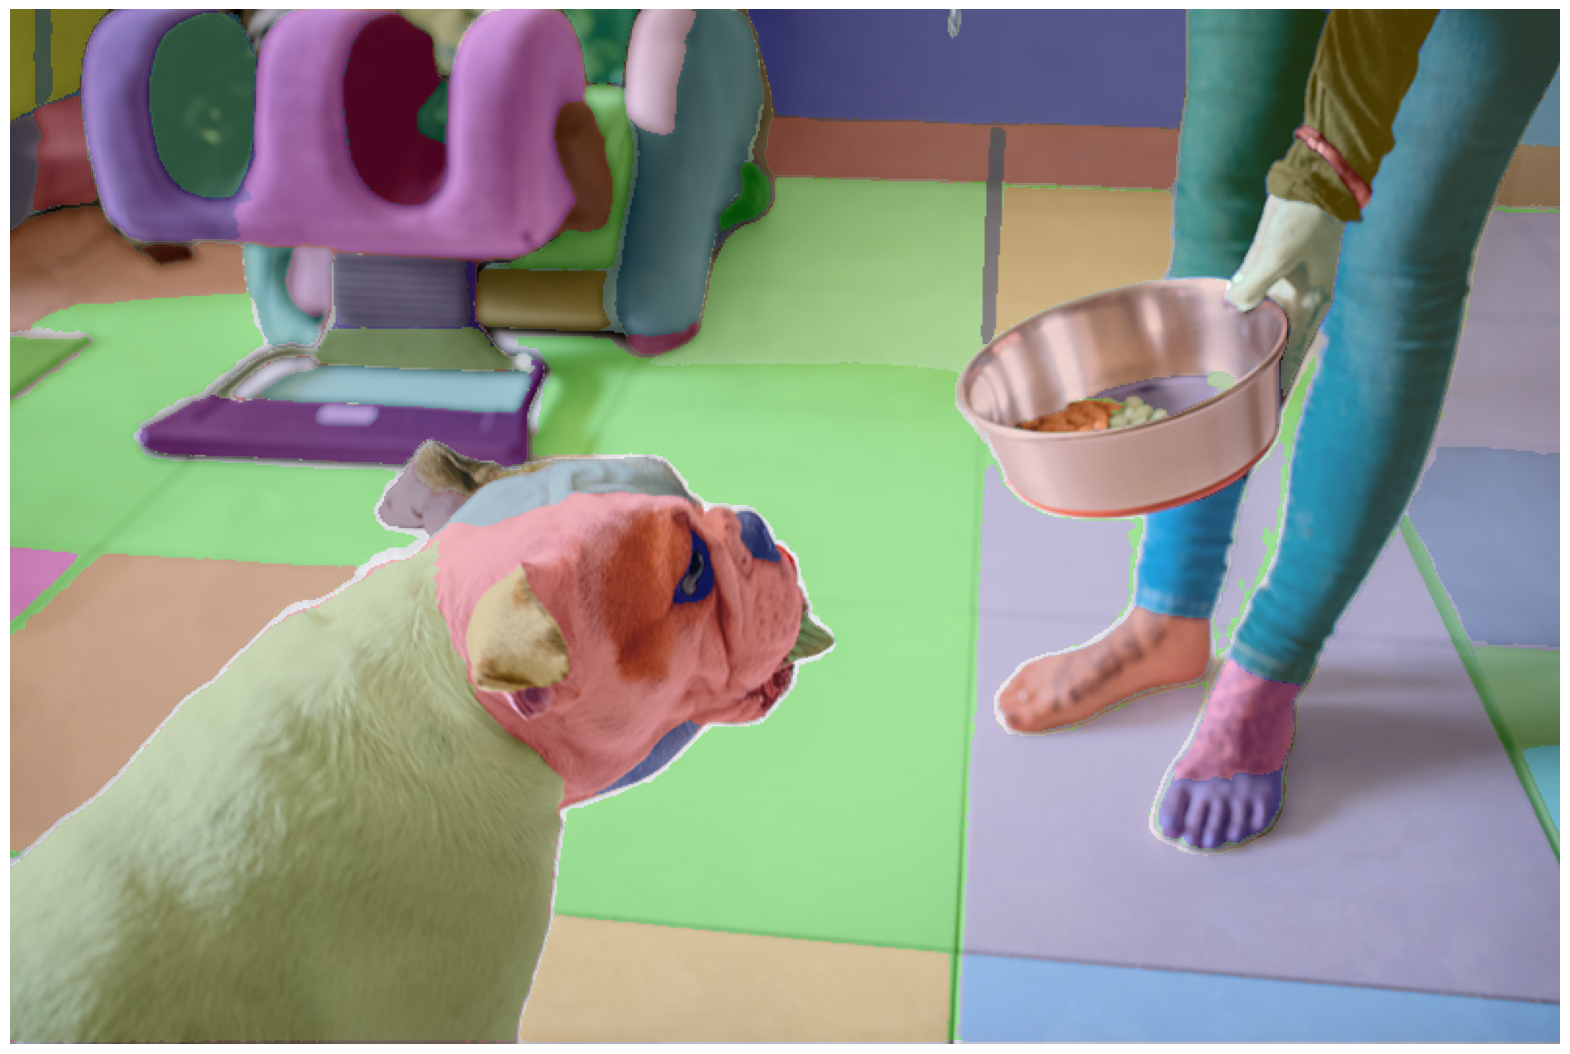

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()